# Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

from qiskit.opflow import Zero, One, I, X, Y, Z

import warnings
warnings.filterwarnings('ignore')

# Importing standard Qiskit modules
from qiskit import QuantumCircuit, QuantumRegister, IBMQ, execute, transpile
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter

# Import state tomography modules
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

import qutip as qt

In [2]:
# load IBMQ Account data

# on first use run:
# IBMQ.save_account(TOKEN)  # replace TOKEN with your API token string (https://quantum-computing.ibm.com/lab/docs/iql/manage/account/ibmq)

provider = IBMQ.load_account()

In [3]:
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')
jakarta = provider.get_backend('ibmq_jakarta')
sim_noisy_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))
sim = QasmSimulator()

# System Setup

In [4]:
# Returns the matrix representation of the XXX Heisenberg model for 3 spin-1/2 particles in a line
def H_heis3():
    # Interactions (I is the identity matrix; X, Y, and Z are Pauli matricies; ^ is a tensor product)
    XXs = (I^X^X) + (X^X^I)
    YYs = (I^Y^Y) + (Y^Y^I)
    ZZs = (I^Z^Z) + (Z^Z^I)
    
    # Sum interactions
    H = XXs + YYs + ZZs
    
    # Return Hamiltonian
    return H

# Returns the matrix representation of U_heis3(t) for a given time t assuming an XXX Heisenberg Hamiltonian for 3 spins-1/2 particles in a line
def U_heis3(t):
    # Compute XXX Hamiltonian for 3 spins in a line
    H = H_heis3()
    
    # Return the exponential of -i multipled by time t multipled by the 3 spin XXX Heisenberg Hamilonian 
    return (t * H).exp_i()

# Classical Solution

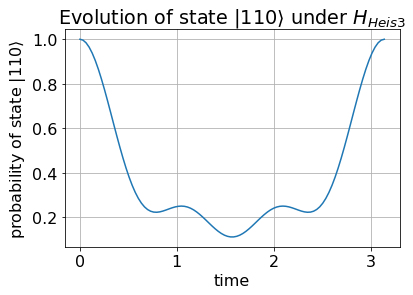

In [5]:
# Define array of time points
ts = np.linspace(0, np.pi, 100)

# Define initial state |110>
initial_state = One^One^Zero

# Compute probability of remaining in |110> state over the array of time points
 # ~initial_state gives the bra of the initial state (<110|)
 # @ is short hand for matrix multiplication
 # U_heis3(t) is the unitary time evolution at time t
 # t needs to be wrapped with float(t) to avoid a bug
 # (...).eval() returns the inner product <110|U_heis3(t)|110>
 #  np.abs(...)**2 is the modulus squared of the innner product which is the expectation value, or probability, of remaining in |110>
probs_110 = [np.abs((~initial_state @ U_heis3(float(t)) @ initial_state).eval())**2 for t in ts]

# Plot evolution of |110>
plt.plot(ts, probs_110)
plt.xlabel('time')
plt.ylabel(r'probability of state $|110\rangle$')
plt.title(r'Evolution of state $|110\rangle$ under $H_{Heis3}$')
plt.grid()
plt.show()

# Qiskit Solution Example

In [10]:
# Parameterize variable t to be evaluated at t=pi later
t = Parameter('t')

In [11]:
# Build a subcircuit for XX(t) two-qubit gate
XX_qr = QuantumRegister(2)
XX_qc = QuantumCircuit(XX_qr, name='XX')

XX_qc.ry(np.pi/2,[0,1])
XX_qc.cnot(0,1)
XX_qc.rz(2 * t, 1)
XX_qc.cnot(0,1)
XX_qc.ry(-np.pi/2,[0,1])

# Convert custom quantum circuit into a gate
XX = XX_qc.to_instruction()

In [12]:
# Build a subcircuit for YY(t) two-qubit gate
YY_qr = QuantumRegister(2)
YY_qc = QuantumCircuit(YY_qr, name='YY')

YY_qc.rx(np.pi/2,[0,1])
YY_qc.cnot(0,1)
YY_qc.rz(2 * t, 1)
YY_qc.cnot(0,1)
YY_qc.rx(-np.pi/2,[0,1])

# Convert custom quantum circuit into a gate
YY = YY_qc.to_instruction()

In [13]:
# Build a subcircuit for ZZ(t) two-qubit gate
ZZ_qr = QuantumRegister(2)
ZZ_qc = QuantumCircuit(ZZ_qr, name='ZZ')

ZZ_qc.cnot(0,1)
ZZ_qc.rz(2 * t, 1)
ZZ_qc.cnot(0,1)

# Convert custom quantum circuit into a gate
ZZ = ZZ_qc.to_instruction()

In [14]:
# Combine subcircuits into a single multiqubit gate representing a single trotter step
num_qubits = 3

Trot_qr = QuantumRegister(num_qubits)
Trot_qc = QuantumCircuit(Trot_qr, name='Trot')

for i in range(0, num_qubits - 1):
    Trot_qc.append(ZZ, [Trot_qr[i], Trot_qr[i+1]])
    Trot_qc.append(YY, [Trot_qr[i], Trot_qr[i+1]])
    Trot_qc.append(XX, [Trot_qr[i], Trot_qr[i+1]])

# Convert custom quantum circuit into a gate
Trot_gate = Trot_qc.to_instruction()

#### Time Evolution

In [15]:
# The final time of the state evolution
target_time = np.pi

# Number of trotter steps
trotter_steps = 4  ### CAN BE >= 4

# Initialize quantum circuit for 3 qubits
qr = QuantumRegister(7)
qc = QuantumCircuit(qr)

# Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
qc.x([3,5])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

# Simulate time evolution under H_heis3 Hamiltonian
for _ in range(trotter_steps):
    qc.append(Trot_gate, [qr[1], qr[3], qr[5]])

# Evaluate simulation at target_time (t=pi) meaning each trotter step evolves pi/trotter_steps in time
qc = qc.bind_parameters({t: target_time/trotter_steps})

# Generate state tomography circuits to evaluate fidelity of simulation
st_qcs = state_tomography_circuits(qc, [qr[1], qr[3], qr[5]])

# Display circuit for confirmation
# st_qcs[-1].decompose().draw()  # view decomposition of trotter gates
st_qcs[-1].draw()  # only view trotter gates

░          
q4_0: ──────────────────────────────────────────────────────────────░──────────
           ┌────────────┐┌────────────┐┌────────────┐┌────────────┐ ░ ┌─┐      
q4_1: ─────┤0           ├┤0           ├┤0           ├┤0           ├─░─┤M├──────
           │            ││            ││            ││            │ ░ └╥┘      
q4_2: ─────┤            ├┤            ├┤            ├┤            ├─░──╫───────
      ┌───┐│            ││            ││            ││            │ ░  ║ ┌─┐   
q4_3: ┤ X ├┤1 Trot(π/4) ├┤1 Trot(π/4) ├┤1 Trot(π/4) ├┤1 Trot(π/4) ├─░──╫─┤M├───
      └───┘│            ││            ││            ││            │ ░  ║ └╥┘   
q4_4: ─────┤            ├┤            ├┤            ├┤            ├─░──╫──╫────
      ┌───┐│            ││            ││            ││            │ ░  ║  ║ ┌─┐
q4_5: ┤ X ├┤2           ├┤2           ├┤2           ├┤2           ├─░──╫──╫─┤M├
      └───┘└────────────┘└────────────┘└────────────┘└────────────┘ ░  ║  ║ └╥┘
q4_6: ──────────────────────────────────────────────────────────────░──╫──╫──╫─
                                                                    ░  ║  ║  ║ 
c0: 3/═════════════════════════════════════════════════════════════════╩══╩══╩═
                                                                       0  1  2

#### Execute

In [16]:
shots = 8192
reps = 8
backend = sim_noisy_jakarta
# reps = 8
# backend = jakarta

jobs = []
for _ in range(reps):
    # execute
    job = execute(st_qcs, backend, shots=shots)
    print('Job ID', job.job_id())
    jobs.append(job)

Job ID ef7a5ae6-f74f-41ea-be12-7084e376fd93
Job ID 5f7ba92e-a24c-4fb5-ad0c-b8a7b17fdf7e
Job ID 1c1ad1a2-0edf-46b1-8555-31768ae83ba0
Job ID 1f247cc3-11a8-48e4-a173-67ea675acffb
Job ID 835373b6-312a-4dec-8782-e1a419714f5d
Job ID 8b620515-bbfc-48d9-ac26-ecd067d86f9e
Job ID cb32f555-61dc-4d2b-9b19-5052b16b0662
Job ID de2de709-18f2-4760-9e80-ea6d147d4cd7


In [17]:
for job in jobs:
    job_monitor(job)
    try:
        if job.error_message() is not None:
            print(job.error_message())
    except:
        pass

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


#### Result Analysis

In [18]:
# Compute the state tomography based on the st_qcs quantum circuits and the results from those ciricuits
def state_tomo(result, st_qcs):
    # The expected final state; necessary to determine state tomography fidelity
    target_state = (One^One^Zero).to_matrix()  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)
    # Fit state tomography results
    tomo_fitter = StateTomographyFitter(result, st_qcs)
    rho_fit = tomo_fitter.fit(method='lstsq')
    # Compute fidelity
    fid = state_fidelity(rho_fit, target_state)
    return fid

# Compute tomography fidelities for each repetition
fids = []
for job in jobs:
    fid = state_tomo(job.result(), st_qcs)
    fids.append(fid)
    
print('state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

state tomography fidelity = 0.0555 ± 0.0011


# Higher Order (Zassenhaus Formula)

### 1-5 Decomposition of $U_{\text{Heis3}}(t)$ Into Quantum Gates

The Hamiltonian on spins $i$ and $j$ ($i,j \in \{0,1,2\}$) would be

$$H^{(i,j)}_{\text{Heis2}} = \sigma_x^{(i)}\sigma_x^{(j)} + \sigma_y^{(i)}\sigma_y^{(j)} + \sigma_z^{(i)}\sigma_z^{(j)}$$

Rewritting $U_{\text{Heis3}}(t)$ in terms of the two possible subsystems within the total $N=3$ system you will simulate,

$$
U_{\text{Heis3}}(t) = \exp\left[-i t \left(H^{(0,1)}_{\text{Heis2}} + H^{(1,2)}_{\text{Heis2}} \right)\right].
$$

$H^{(0,1)}_{\text{Heis2}}$ and $H^{(1,2)}_{\text{Heis2}}$ do not commute, so $U_{\text{Heis3}}(t) \neq \exp\left(-i t H^{(0,1)}_{\text{Heis2}}\right) \exp\left(-i t H^{(1,2)}_{\text{Heis2}} \right)$. But, let's use the Zassenhaus Formula to find a second-order Trotterization for $U_{\text{Heis3}}(t)$.

$$
\begin{align}
U_{\text{Heis3}}(t) &= \exp\left[-i t \left(H^{(0,1)}_{\text{Heis2}} + H^{(1,2)}_{\text{Heis2}} \right)\right] \\
U_{\text{Heis3}}(t) &\approx \left[\exp\left(\dfrac{-it}{n}H^{(0,1)}_{\text{Heis2}}\right) \exp\left(\dfrac{-it}{n}H^{(1,2)}_{\text{Heis2}} \right) \exp\left(\dfrac{-(-it)^2}{2n}\left[H^{(0,1)}_{\text{Heis2}},H^{(1,2)}_{\text{Heis2}}\right] \right)\right]^n.
\end{align}
$$

Next, let's calculate $\left[H^{(0,1)}_{\text{Heis2}},H^{(1,2)}_{\text{Heis2}}\right]$. 

$$\left[H^{(0,1)}_{\text{Heis2}},H^{(1,2)}_{\text{Heis2}}\right] = [\sigma_x^{(0)}\sigma_x^{(1)} + \sigma_y^{(0)}\sigma_y^{(1)} + \sigma_z^{(0)}\sigma_z^{(1)}, \sigma_x^{(1)}\sigma_x^{(2)} + \sigma_y^{(1)}\sigma_y^{(2)} + \sigma_z^{(1)}\sigma_z^{(2)}]$$

$$= \sigma_x^{(0)}\sigma_y^{(2)}[\sigma_x^{(1)},\sigma_y^{(1)}] + \sigma_x^{(0)}\sigma_z^{(2)}[\sigma_x^{(1)},\sigma_z^{(1)}] + \sigma_y^{(0)}\sigma_x^{(2)}[\sigma_y^{(1)},\sigma_x^{(1)}] + \sigma_y^{(0)}\sigma_z^{(2)}[\sigma_y^{(1)},\sigma_z^{(1)}] + \sigma_z^{(0)}\sigma_x^{(2)}[\sigma_z^{(1)},\sigma_x^{(1)}] + 
\sigma_z^{(0)}\sigma_y^{(2)}[\sigma_z^{(1)},\sigma_y^{(1)}]$$

$$= 2i\left\{\sigma_x^{(0)}\sigma_y^{(2)}(\sigma_z^{(1)}) + \sigma_x^{(0)}\sigma_z^{(2)}(-\sigma_y^{(1)}) + \sigma_y^{(0)}\sigma_x^{(2)}(-\sigma_z^{(1)}) + \sigma_y^{(0)}\sigma_z^{(2)}(\sigma_x^{(1)}) + \sigma_z^{(0)}\sigma_x^{(2)}(\sigma_y^{(1)}) + 
\sigma_z^{(0)}\sigma_y^{(2)}(-\sigma_x^{(1)})\right\}$$

In [25]:
sx = qt.sigmax()
sy = qt.sigmay()
sz = qt.sigmaz()
I = qt.identity(2)
xo = qt.tensor

H01 = xo(sx,sx,I) + xo(sy,sy,I) + xo(sz,sz,I)
H12 = xo(I,sx,sx) + xo(I,sy,sy) + xo(I,sz,sz)

take_comm = lambda x, y: x*y - y*x
comm = take_comm(H01,H12)

comm_manual = 2j*(xo(sx,sz,sy) - xo(sx,sy,sz) - xo(sy,sz,sx) + xo(sy,sx,sz) + xo(sz,sy,sx) - xo(sz,sx,sy))
take_comm(xo(sx,sz,sy) - xo(sx,sy,sz),  - xo(sy,sz,sx) + xo(sy,sx,sz))


Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = False
Qobj data =
[[ 0.  0.  0. -4.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 4.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  4.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -4.  0.  0.  0.]]


$n$ is the number of Trotter steps, and as $n$ increases, the approximation becomes more accurate. (Note that how a untiary is split up into subsystems for Trotterization is not necessarily unique.) The decomposition goes further. Within each 2 spin subsystems, the Pauli operator pairs ($\sigma_x^{(i)}\sigma_x^{(j)}$, $\sigma_y^{(i)}\sigma_y^{(j)}$, and $\sigma_z^{(i)}\sigma_z^{(j)}$) commute. This means we can decompose the exponential of a subsystem Hamiltonian ($H^{(i,j)}_{\text{Heis2}}$) into a product of even simpler exponentials getting us closer to a gate implementation of $U_{\text{Heis3}}(t)$

$$
\begin{align}
U_{\text{Heis3}}(t) &\approx \left[\exp\left(\dfrac{-it}{n}H^{(0,1)}_{\text{Heis2}}\right) \exp\left(\dfrac{-it}{n}H^{(1,2)}_{\text{Heis2}} \right)\right]^n \\
U_{\text{Heis3}}(t) &\approx \left[\exp\left(\dfrac{-it}{n}\left(\sigma_x^{(0)}\sigma_x^{(1)} + \sigma_y^{(0)}\sigma_y^{(1)} + \sigma_z^{(0)}\sigma_z^{(1)}\right)\right) \exp\left(\dfrac{-it}{n}\left(\sigma_x^{(1)}\sigma_x^{(2)} + \sigma_y^{(1)}\sigma_y^{(2)} + \sigma_z^{(1)}\sigma_z^{(2)}\right)\right)\right]^{n} \\
U_{\text{Heis3}}(t) &\approx \left[\exp\left(\dfrac{-it}{n}\sigma_x^{(0)}\sigma_x^{(1)}\right) \exp\left(\dfrac{-it}{n}\sigma_y^{(0)}\sigma_y^{(1)}\right) \exp\left(\dfrac{-it}{n}\sigma_z^{(0)}\sigma_z^{(1)}\right) \exp\left(\dfrac{-it}{n}\sigma_x^{(1)}\sigma_x^{(2)}\right) \exp\left(\dfrac{-it}{n}\sigma_y^{(1)}\sigma_y^{(2)}\right) \exp\left(\dfrac{-it}{n}\sigma_z^{(1)}\sigma_z^{(2)}\right)\right]^{n}
\end{align}
$$

For simplicity, and to use more common notation, let's rename the products with $XX(2t) = \exp\left(-it \sigma_x\sigma_x\right)$, $YY(2t) = \exp\left(-it \sigma_y\sigma_y\right)$, and $ZZ(2t) = \exp\left(-it \sigma_z\sigma_z\right)$ and rewrite the Trotterized $U_{\text{Heis3}}(t)$
$$
U_{\text{Heis3}}(t) \approx \left[XX\left(\frac{2t}{n}\right)^{(0,1)} YY\left(\frac{2t}{n}\right)^{(0,1)} ZZ\left(\frac{2t}{n}\right)^{(0,1)} XX\left(\frac{2t}{n}\right)^{(1,2)} YY\left(\frac{2t}{n}\right)^{(1,2)} ZZ\left(\frac{2t}{n}\right)^{(1,2)} \right]^{n}
$$
And that's it! We have now approximately decomposed $U_{\text{Heis3}}(t)$ into two-qubit gates $XX(t)$, $YY(t)$, and $ZZ(t)$. These gates are not native to superconducting qubits, but in Section 2, they will be further decomposed into native single and two-qubit gates with *further details found in the supplementary material.*


\[1\] Y. Salathe, et al., *Digital Quantum Simulation of Spin Models with Circuit Quantum Electrodynamics*, [Phys. Rev. X **5**, 021027 (2015)](https://link.aps.org/doi/10.1103/PhysRevX.5.021027)

\[2\] F. Tacchino, et al., *Quantum Computers as Universal Quantum Simulators: State-of-the-Art and Perspectives*, [Adv. Quantum Technol. *3* 3 (2020)](https://doi.org/10.1002/qute.201900052) \[[free arxiv version](https://arxiv.org/abs/1907.03505)\]
